In [1]:
# Class to use
import sys
sys.path.append("../../python")
from auditing_setup.election_setting import Election

import matplotlib as mpl
from matplotlib import rc, rc_params
from matplotlib import pyplot as plt
from scipy.stats import binom
import seaborn as sns

# Class to use
import sys
sys.path.append("../../python")
from auditing_setup.election_setting import Election
from auditing_setup.audit_methods import *

plt.rc('font', family='serif', serif='Times')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
sns.set(style="darkgrid")
sns.set(font_scale=2)
def toggle_tex(to=None):
    if to is not None:
        rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
        rc('text', usetex=to)
    elif mpl.rcParams['text.usetex']:
        rc('text', usetex=False)
    else:
        rc('text', usetex=True)
mpl.rcParams["savefig.dpi"] = 600
        
toggle_tex(to=False)
%matplotlib inline

/Users/Dovermore/.conda/envs/audit_analysis/lib/R


# All boundary for without replacement version

In [2]:
election = Election(500, 500)

methods = dict(
    BRAVO = BRAVO(0.55, alpha=0.05),
)

In [3]:
from collections import defaultdict

boundaries = defaultdict(list)

for t in range(1, 500):
    for name, method in methods.items():
        for y_t in range(t//2, t):
            if method(500, t, y_t):
                boundaries[name].append(y_t)
                break
        else:
            boundaries[name].append(None)
            
    lst = list(len(i) for i in boundaries.values())
    if not lst[1:] == lst[:-1]:
        for i, j in boundaries.items():
            print(i, len(j), len([i for i in j if i is None]), lst, t, y_t)

In [4]:
from numpy.random import rand

In [5]:
from numpy import cumsum

In [6]:
p = 0.55

sequences = []
for i in range(3):
    sequence = []
    while len(sequence)+1 <= len(boundaries['BRAVO']):
        if p > rand(1)[0]:
            sequence.append((sequence[-1] if len(sequence) > 0 else 0) + 1)
        else:
            sequence.append((sequence[-1] if len(sequence) > 0 else 0))
        if boundaries['BRAVO'][len(sequence)-1] is not None and sequence[-1] >= boundaries['BRAVO'][len(sequence)-1]:
            break
    sequence = [v/(i+1) for i,v in enumerate(sequence)]
    sequences.append(sequence)
sequences = pd.DataFrame(sequences).transpose()
sequences

,0,1,2
0,1.000000,0.000000,1.000000
1,1.000000,0.500000,0.500000
2,1.000000,0.666667,0.333333
3,1.000000,0.750000,0.250000
4,0.800000,0.600000,0.400000
5,0.666667,0.500000,0.500000
6,0.714286,0.571429,0.428571
7,0.625000,0.500000,0.375000
8,0.555556,0.555556,0.444444
9,0.600000,0.500000,0.500000


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

boundaries_df = pd.DataFrame(boundaries)
boundaries_df.head()

,BRAVO
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [21]:
boundaries_df.reset_index(col_fill='index', inplace=True)
boundaries_df['index'] += 1
for col in boundaries_df.columns:
    if col != 'index':
        boundaries_df[col] = boundaries_df[col] / boundaries_df['index']
boundaries_df.set_index('index', inplace=True)
boundaries_df.fillna(1.01, inplace=True)

In [22]:
def pivot_widetable(df, names, groupers, *args, **kwargs):
    df_long = df.melt(*args, **kwargs)
    for name, grouper in zip(names, groupers):
        group = [grouper(i) for i in df_long['variable']]
        df_long[name] = group
    return df_long

In [23]:
names = [
    'type',
    'parameter'
]

def group_type(name):
    if 'max' in name.lower():
        return 'MaxBRAVO'
    if 'bravo' in name.lower():
        return 'BRAVO'
    if 'bayesian' in name.lower():
        return 'Bayesian'
    else:
        return name
    
def group_parameter(name):
    return name.lower().replace(group_type(name).lower(), "")
    
groupers = [
    group_type,
    group_parameter
]

boundaries_df_long = pivot_widetable(boundaries_df.reset_index(), names, groupers, id_vars='index')

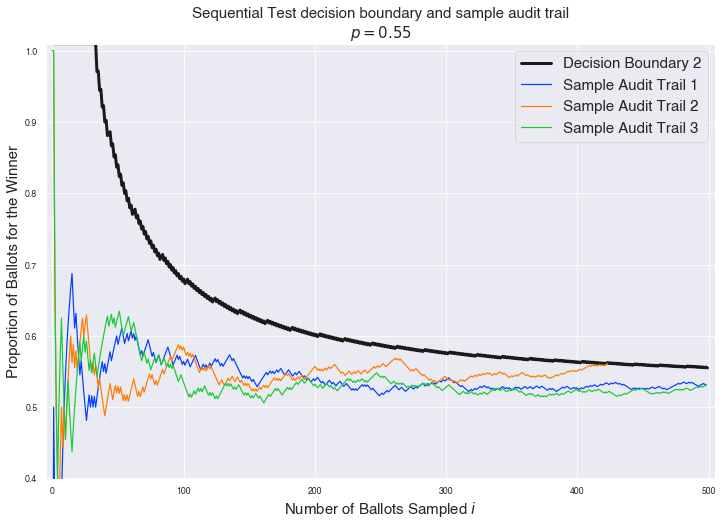

In [25]:
import seaborn as sns
sns.set_context("paper")

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
dash_styles = [(1, 0),
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]
dash_styles = [ [3*x for x in L ] for L in dash_styles ]

# dash_styles = ['-',
#                '-',
#                '--',
#                (20, 10),
#                (10, 5),
#                (5, 5, 2, 5),
#                (3, 3, 1, 1)]

current_palette = sns.color_palette('hls', 6)
palatte = [
    current_palette[1],
    current_palette[1],
    current_palette[1],
    current_palette[0],
    current_palette[0],
    current_palette[4],
    current_palette[5],
]

lws = [
    100, 5, 3,
    5, 3,
    5, 3
]

alphas = [
    
]

plt.figure(figsize=[12, 8])

ax = sns.lineplot(x='index', 
             y='value', 
             data=boundaries_df_long, 
             legend=None,
             linewidth=3,
             c='k'
            )
sns.lineplot(data=sequences, dashes=False, palette=sns.color_palette('bright', 3))

fontsize = 15
plt.ylim([0.4,1.01])
plt.xlim([-5,505])
plt.ylabel(r'Proportion of Ballots for the Winner', fontsize=fontsize)
plt.xlabel(r'Number of Ballots Sampled $i$', fontsize=fontsize)
ax.set_title('Sequential Test decision boundary and sample audit trail\n$p=0.55$', fontsize=fontsize)

plt.legend([
    r'Decision Boundary 2',
    r'Sample Audit Trail 1',
    r'Sample Audit Trail 2',
    r'Sample Audit Trail 3',
], fontsize=fontsize)